In [123]:
import os
import numpy as np
import pandas as pd
import sklearn
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from gensim.models import word2vec
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import torch.nn.utils.rnn as rnn_utils

Разархивируйте данные в папку где находится ноутбук

## Без текстового преобразования

Примечание ноутбук не доделан полностью, отсутствуют рабочая функця по обучение сети с испольованием текствоых данных

In [66]:
tesla_stock = pd.read_csv("tesla_stock_news/tesla_processed.csv") # Загружаем датасет

In [91]:
print(tesla_stock[tesla_stock["Date"]=="2022-02-04 09:35:00"]["News"].values)
print(tesla_stock[tesla_stock["Date"]=="2022-02-04 12:30:00"]["News"].values)
print(tesla_stock[tesla_stock["Date"]=="2022-02-04 15:30:00"]["News"].values)

["['Ather charges at Ola; founders drive Shark Tank’s meme-plosion\\nAther Energy, an electric-vehicle startup backed by Hero MotoCorp, has started work on new electric scooters that promise better range and more bang for your buck.\\n', 'What to know about the mysterious world of cryptocurrencies\\nCryptocurrencies, which ballooned during the pandemic, have lost over $1 trillion in market cap in a couple of months.\\n', 'Grover guns for BharatPe CEO; no tax breaks for Tesla\\nAshneer Grover, the embattled founder and managing director of BharatPe, has asked the company’s board members to remove CEO Suhail Sameer from the board.\\n', 'What to know about the mysterious world of cryptocurrencies\\nIn her Union Budget 2022 speech, FM Nirmala Sitharaman said crypto transactions will be taxed at 30%. The Budget proposed that no deductions will be allowed except cost of acquisition and losses can’t be set off against other income.\\n']"]
["['Ather charges at Ola; founders drive Shark Tank’s 

In [72]:
tesla_stock["Date"] = pd.to_datetime(tesla_stock["Date"],dayfirst=False) # Преобразовываем дату

In [77]:
times = ['09:35', '12:30', '15:30'] # Выбираем определенное время для датасета (выбор был исходя из изменения новостей)
mask = tesla_stock["Date"].dt.time.isin([pd.to_datetime(f'1970-01-01 {t}').time() for t in times]) # Создаем маску
filtered_df = tesla_stock[mask] # Фильтруем значения

In [78]:
filtered_df

,Date,Open,High,Low,Close,Volume,News
5,2015-01-02 09:35:00,14.822,14.824,14.736,14.743,447735,
180,2015-01-02 12:30:00,14.387,14.390,14.376,14.382,26265,
360,2015-01-02 15:30:00,14.549,14.555,14.541,14.555,94170,
395,2015-01-05 09:35:00,14.351,14.363,14.298,14.303,246060,
570,2015-01-05 12:30:00,13.918,13.918,13.898,13.911,103125,
...,...,...,...,...,...,...,...
863931,2023-10-30 12:30:00,198.200,198.620,198.175,198.450,280058,"[""The consequences of Elon Musk's ownership of..."
864111,2023-10-30 15:30:00,198.100,198.220,197.980,197.984,223122,"[""The consequences of Elon Musk's ownership of..."
864146,2023-10-31 09:35:00,196.590,196.690,194.650,195.130,1005719,"[""Elon Musk's throwback Halloween pic with mom..."
864321,2023-10-31 12:30:00,197.715,197.820,197.620,197.760,160739,"[""Elon Musk's throwback Halloween pic with mom..."


In [79]:
def prepare_date(df):
    df['month'] = df.Date.dt.month
    df['quarter']= df.Date.dt.quarter
    df['day'] = df.Date.dt.day
    df['dayweek'] = df.Date.dt.dayofweek
    df['Close'] = df['Close'].shift(-1)
    df = df.drop(df.index[-1])
    del df["Date"]
    
    return df
df_tr = prepare_date(filtered_df.copy())

In [80]:
df_tr.shape

(6651, 10)

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Neural_regression(nn.Module):
    def __init__(self,input_shape_stock):
        super().__init__()
        self.all_block = nn.Sequential(
        nn.Linear(input_shape_stock, 128),
        # nn.ReLU(),
        nn.Linear(128, 64),
        nn.Linear(64, 32),
        nn.Linear(32, 1),
        )
    def forward(self, x):
        x = self.all_block(x)
        return x

In [95]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data_x = data.drop(["Close","News"],axis=1)
        self.data_y = data["Close"]
        self.scaler_X = MinMaxScaler()
        self.scaler_Y = MinMaxScaler()
        self.data_x = self.scaler_X.fit_transform(self.data_x)
        self.data_y = self.scaler_Y.fit_transform(self.data_y.values.reshape(-1,1))
        # self.data = data

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        # print(self.data_x)
        x = self.data_x[idx]
        y = self.data_y[idx]
        # sample = self.data.iloc[idx]
        sample_x = torch.tensor(x, dtype=torch.float32)
        sample_y = torch.tensor(y, dtype=torch.float32)
        # Process sample here if needed
        return (sample_x,sample_y)
    def denormalize(self, predict, y):
        predict_denormalized = self.scaler_Y.inverse_transform(predict.cpu().numpy())[:, 0]
        y_denormalized = self.scaler_Y.inverse_transform(y.cpu().numpy())[:, 0]
        x = torch.tensor(predict_denormalized, dtype=torch.float32)
        y = torch.tensor(y_denormalized, dtype=torch.float32)
        return x,y

In [84]:
df_tr[:~400]

,Open,High,Low,Close,Volume,News,month,quarter,day,dayweek
5,14.822,14.824,14.736,14.382,447735,,1,1,2,4
180,14.387,14.390,14.376,14.555,26265,,1,1,2,4
360,14.549,14.555,14.541,14.303,94170,,1,1,2,4
395,14.351,14.363,14.298,13.911,246060,,1,1,5,0
570,13.918,13.918,13.898,13.935,103125,,1,1,5,0
...,...,...,...,...,...,...,...,...,...,...
811670,181.960,182.000,181.800,182.800,154584,['Ahead of Market: 10 things that will decide ...,4,2,19,2
811850,182.910,182.910,182.696,167.633,284775,['Ahead of Market: 10 things that will decide ...,4,2,19,2
811885,167.320,167.970,166.990,163.351,1013866,"[""Elon Musk's '4/20' deadline is here: Twitter...",4,2,20,3
812060,163.451,163.470,163.220,161.400,267751,"[""Elon Musk's '4/20' deadline is here: Twitter...",4,2,20,3


In [96]:
# x,y =  DataLoader(dataset=df_tr, batch_size=1)
df_train,df_test = df_tr[:~250],df_tr[~250:]
dataset = CustomDataset(df_train)

dataloader_train = DataLoader(dataset, batch_size=8)
dataset_test = CustomDataset(df_test)
dataloader_test = DataLoader(dataset_test, batch_size=8)
# x,y = df_tr.drop("Close",axis=1),df_tr["Close"]

In [86]:
df_tr[~250:]

,Open,High,Low,Close,Volume,News,month,quarter,day,dayweek
831775,278.843,279.397,278.620,279.540,585053,"[""GIFT Nifty up 5 points; here's what changed ...",7,3,5,2
831950,279.380,279.700,279.280,282.389,296336,"[""GIFT Nifty up 5 points; here's what changed ...",7,3,5,2
832130,282.310,282.500,282.230,277.410,474066,Threads Memes: Meta launches new 'Threads' app...,7,3,5,2
832165,278.420,278.560,277.220,278.019,1151476,"[""Tesla's Autopilot driver-assist system gets ...",7,3,6,3
832340,277.910,278.030,277.710,277.787,246538,"[""Tesla's Autopilot driver-assist system gets ...",7,3,6,3
...,...,...,...,...,...,...,...,...,...,...
863756,209.840,210.100,208.920,198.450,609774,"[""The consequences of Elon Musk's ownership of...",10,4,30,0
863931,198.200,198.620,198.175,197.984,280058,"[""The consequences of Elon Musk's ownership of...",10,4,30,0
864111,198.100,198.220,197.980,195.130,223122,"[""The consequences of Elon Musk's ownership of...",10,4,30,0
864146,196.590,196.690,194.650,197.760,1005719,"[""Elon Musk's throwback Halloween pic with mom...",10,4,31,1


In [100]:
train_losses = []
val_losses = []

def train(dataloader, model, loss_fn, optimizer,epoch,num_epochs): # Обучение сети
    size = len(dataloader.dataset)
    train_loss = 0.0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = train_loss / size
    print(f"Epoch [{epoch+1:03}/{num_epochs:03}]: Average Loss: {avg_loss:.5f}")
    train_losses.append(avg_loss)
def test(dataloader, model, loss_fn,dataset_test): # Тестовый прогон
    size = len(dataloader.dataset)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred,y).item()
    avg_loss = val_loss / size
    print(f"Validation Loss: {avg_loss:.5f}")
    val_losses.append(avg_loss)
def validate(dataloader, model,dataset_test): # Валидация предсказания с графиком
    size = len(dataloader.dataset)
    model.eval()
    pred_all = []
    y_all = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            predict_norma,y_norma = dataset_test.denormalize(pred,y)
            pred_all.extend(predict_norma.numpy())
            y_all.extend(y_norma.numpy())
    print(len(pred_all))
    print(len(y_all))
    plt.plot(range(len(pred_all)),pred_all,label="Predict")
    plt.plot(range(len(y_all)),y_all,label="Actual")
    plt.legend()
    plt.show()

In [101]:
num_epochs = 30
input_shape_stock = df_train.shape[1]-2
print(input_shape_stock)
input_shape_vector = 100

model = Neural_regression(input_shape_stock)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.to(device)
for i in range(num_epochs):
    train(dataloader_train,model,loss_fn,optimizer,i,num_epochs)
    test(dataloader_test,model,loss_fn,dataset_test)

8
Epoch [001/030]: Average Loss: 0.00031
Validation Loss: 0.00202
Epoch [002/030]: Average Loss: 0.00023
Validation Loss: 0.00064
Epoch [003/030]: Average Loss: 0.00005
Validation Loss: 0.00027
Epoch [004/030]: Average Loss: 0.00001
Validation Loss: 0.00025
Epoch [005/030]: Average Loss: 0.00001
Validation Loss: 0.00025
Epoch [006/030]: Average Loss: 0.00001
Validation Loss: 0.00026
Epoch [007/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [008/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [009/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [010/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [011/030]: Average Loss: 0.00001
Validation Loss: 0.00026
Epoch [012/030]: Average Loss: 0.00001
Validation Loss: 0.00026
Epoch [013/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [014/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [015/030]: Average Loss: 0.00001
Validation Loss: 0.00027
Epoch [016/030]: Average Loss: 0.00001

251
251


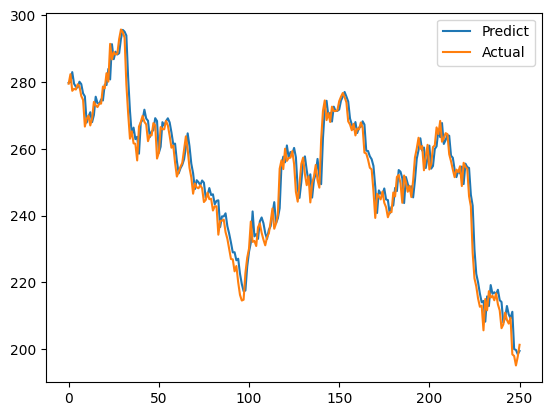

In [102]:
validate(dataloader_test,model,dataset_test)

## Подготовка текстовых данных

Идея заключалась в добавлении текстовых данных для улучшения прогности модели.
Текста в многомерном пространстве или(и) классификация на положительные или отрицательные

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def process_news(text): # Функция для обработки текста
    if text == " ":
        return ["unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow"]
    text = text.replace("\\n"," ")
    text = text.replace("“","")
    text = text.replace("”","")
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
    return tokens


In [ ]:
all_data = [process_news(i) for i in tesla_stock["News"].unique()]

In [ ]:
Word2Vec_model = word2vec.Word2Vec(all_data,min_count=5,window=5,workers=4) # Создаем модель с текстовыми

In [ ]:
Word2Vec_model.wv["bmw"] # Проверяем слова в многомерном пространстве

In [ ]:
Word2Vec_model.wv.save_word2vec_format('word2vec.txt') # Сохраняем модель

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('word2vec.txt', binary=False) # Загружаем модель

In [ ]:
word_embedding = word_vectors["charge"]

In [ ]:
word_vectors.vector_size

In [ ]:
def create_embedding(df,model):
    embed = []
    for new in df["News"].values:
        tmp = []
        for z in process_news(new):
            try:
                tmp.append(model.wv[z])
            except:
                tmp.append("unknow")
        embed.append(tmp)
    return embed

In [ ]:
processed_corpus = []
for doc in nlp.pipe(tesla_stock["News"].values):
    # text = text.replace("\\n"," ")
    # text = text.replace("“","")
    # text = text.replace("”","")
    processed_corpus.append([token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data,word2vec_model):
        self.data = data
        self.word2vec_model = word2vec_model
        
        # Normalize the data
        self.scaler_X = MinMaxScaler()
        self.scaler_Y = MinMaxScaler()
        self.data_x_normalized = self.scaler_X.fit_transform(self.data.drop(["Close","News"], axis=1))
        self.data_y_normalized = self.scaler_Y.fit_transform(self.data["Close"].values.reshape(-1, 1))

    def __len__(self):
        return len(self.data_x_normalized)

    def __getitem__(self, idx):
        x = self.data_x_normalized[idx]
        y = self.data_y_normalized[idx]
        # text = self.create_embedding(self.data,self.word2vec_model)
        text = self.data.iloc[idx]["News"]
        print(self.word2vec_model.wv)
        word_vectors = [self.word2vec_model.wv[word] if word in self.word2vec_model.wv else torch.zeros(self.word2vec_model.vector_size) for word in text]
        # Convert the normalized data to tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return torch.stack(word_vectors), (x, y)
    
    def create_embedding(self,df,model):
        embed = []
        for new in df["News"].values:
            tmp = []
            for z in process_news(new):
                try:
                    tmp.append(model.wv[z])
                except:
                    tmp.append(0.0)
            embed.append(tmp)
        return embed

    def process_news(self,text):
        if text == " ":
            return ["unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow","unknow"]
        text = text.replace("\\n"," ")
        text = text.replace("“","")
        text = text.replace("”","")
        doc = nlp(text)
        tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
        return tokens


    def denormalize(self, predict, y):
        predict_denormalized = self.scaler_Y.inverse_transform(predict.cpu().numpy())[:, 0]
        y_denormalized = self.scaler_Y.inverse_transform(y.cpu().numpy())[:, 0]
        x = torch.tensor(predict_denormalized, dtype=torch.float32)
        y = torch.tensor(y_denormalized, dtype=torch.float32)
        return x,y